In [1]:
# Standard modules
import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import nltk.stem
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller

# Setup matpltlib visualization
%matplotlib inline

In [2]:
# Constants

# Path to words dataset .csv file
WORDS_PATH = 'data/database/words.csv'
HASH_PATH = 'data/database/entities.csv'

In [3]:
# Load hashtags dataset
with open(HASH_PATH, 'r') as file:
    hashtags_data = pd.read_csv(file)

In [4]:
# Clean hashtags dataset

#lowercase hashtags
hashtags_data.loc[:,'text'] = hashtags_data.text.str.lower()

#rename tweet attribute
hashtags_data = hashtags_data.rename({'tweet_id_str':'tweet'}, axis='columns')

hashtags_data.head()

,Unnamed: 0,tweet,type,text
0,0,1207806578650468352,hashtag,thishappened
1,1,1207761285045260294,hashtag,womeninsport
2,2,1207714713326510081,hashtag,loksabha
3,3,1207714713326510081,hashtag,womeninpolitics
4,4,1207699612359749632,hashtag,indiarejectscaa


In [5]:
# Load words dataset
words = pd.read_csv(WORDS_PATH, dtype={
    'tweet': np.unicode_,
    'index': np.int,
    'text': np.unicode_,
    'pos': np.unicode_,
    'conf': np.float
})

# Show few lines of the dataset
words.head()

,tweet,index,text,pos,conf
0,1204199429177315329,0,RT,~,0.9979
1,1204199429177315329,1,@unwomenjordan,@,0.9991
2,1204199429177315329,2,:,~,0.9630
3,1204199429177315329,3,From,P,0.9991
4,1204199429177315329,4,the,D,0.9975


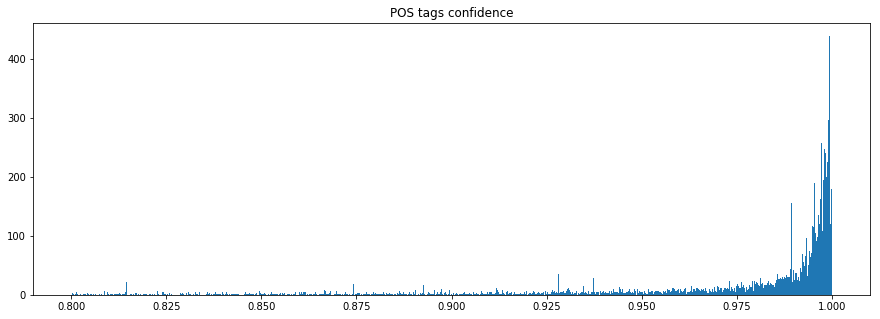

In [6]:
# Show distribution of confidence for POS tags
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.hist(words.conf, bins=1000, range=(0.8, 1.0))
_ = ax.set_title('POS tags confidence')
_ = plt.plot()

In [7]:
# Dataset subset

# Get only verbs (V), adjectives (A), common nouns (N)
words = words[words.pos.isin(['V', 'A', 'N'])]

# Get only words with acceptable confidence (over 0.925)
words = words[words.conf > 0.925]

# Define stopwords list - download the stopword corpus first: nltk.download("stopwords")
stopword = stopwords.words('english')
# Discard stop words
words = words.loc[~words.text.isin(stopword),:]

# Show dataset shape
print('Dataset shape: {:s}'.format(str(words.shape)), end='\n')

# Show ordered dataset
words.sort_values(by=['tweet', 'index'], inplace=True)
words.head()

Dataset shape: (2783, 5)


,tweet,index,text,pos,conf
10,1204199429177315329,10,equal,A,0.9980
11,1204199429177315329,11,work,N,0.9960
16,1204199429177315329,16,leaders,N,0.9717
19,1204199429177315329,19,engage,V,0.9532
30,1204205766342840336,5,small,A,0.9844


In [8]:
# Define Porter stemmer
stemmer = nltk.stem.PorterStemmer()
# Define Lemmatizer - download the wordnet first: nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
# Define Speller
spell = Speller(lang='en')

# Define post processing function
def post_process(word):
    """
    Post processing function, to be applied after words tokenization and POS tagging
    It lowers, stems, lemmatize and corrects spelling of a given word
    """
    word, pos = word.values
    word = word.lower()
    word = re.sub('#','',word)
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word, pos = pos.lower())
    word = spell(word)
    return word

In [9]:
# Post process words in dataset
words.text = words.loc[:,('text','pos')].apply(post_process, axis = 1)
words.head()

,tweet,index,text,pos,conf
10,1204199429177315329,10,equal,A,0.9980
11,1204199429177315329,11,work,N,0.9960
16,1204199429177315329,16,leader,N,0.9717
19,1204199429177315329,19,engage,V,0.9532
30,1204205766342840336,5,small,A,0.9844


In [10]:
# Creation of a type field
words['type'] = ['word'] * words.shape[0]

In [11]:
# Create a words dataframe without some useless fields
words_ = words[['tweet', 'text', 'type']] #type or pos?
words_.to_csv('data/database/words_cleaned.csv')
words_.head()

,tweet,text,type
10,1204199429177315329,equal,word
11,1204199429177315329,work,word
16,1204199429177315329,leader,word
19,1204199429177315329,engage,word
30,1204205766342840336,small,word


In [12]:
# Concepts dataframe creation - words and hashtags
concepts = pd.concat([words_,hashtags_data[['tweet','type','text']]],sort = False)
concepts = concepts[~concepts[['tweet','text']].duplicated(keep=False)]
concepts.loc[:,'tweet'] = concepts.tweet.astype('int')
concepts.to_csv('data/database/concepts.csv')

concepts.head()

,tweet,text,type
10,1204199429177315329,equal,word
11,1204199429177315329,work,word
16,1204199429177315329,leader,word
19,1204199429177315329,engage,word
30,1204205766342840336,small,word


In [13]:
# Map each unique concept to a number and vice versa 
c2i, i2c = dict(), dict()
for index, conc in enumerate(set(concepts.text)):
    c2i[conc] = index
    i2c[index] = conc

In [14]:
# Creation of an index field
concepts['index'] = concepts.text.map(c2i)

In [15]:
# Build relationships: join each word with each word in the same tweet
edges = pd.merge(concepts, concepts, on='tweet')
edges.head()

,tweet,text_x,type_x,index_x,text_y,type_y,index_y
0,1204199429177315329,equal,word,251,equal,word,251
1,1204199429177315329,equal,word,251,work,word,648
2,1204199429177315329,equal,word,251,leader,word,1184
3,1204199429177315329,equal,word,251,engage,word,680
4,1204199429177315329,work,word,648,equal,word,251


In [16]:
# Remove matches between the same word
edges = edges[edges.index_x != edges.index_y]
edges.head()

,tweet,text_x,type_x,index_x,text_y,type_y,index_y
1,1204199429177315329,equal,word,251,work,word,648
2,1204199429177315329,equal,word,251,leader,word,1184
3,1204199429177315329,equal,word,251,engage,word,680
4,1204199429177315329,work,word,648,equal,word,251
6,1204199429177315329,work,word,648,leader,word,1184


In [18]:
# Count how many times the same word matches have been found
edges = edges.groupby(['text_x', 'text_y']).size().reset_index(name='counts')
edges.head()

,text_x,text_y,counts
0,16days,abuse,1
1,16days,action,1
2,16days,active,2
3,16days,authoritarian,1
4,16days,backlash,1


In [19]:
# Map each word to a numeric index
edges['number_x'] = edges.text_x.map(c2i)
edges['number_y'] = edges.text_y.map(c2i)
edges.head()

,text_x,text_y,counts,number_x,number_y
0,16days,abuse,1,47,1004
1,16days,action,1,47,1143
2,16days,active,2,47,1112
3,16days,authoritarian,1,47,633
4,16days,backlash,1,47,829


In [20]:
# Build adjacency matrix - binary

# Define set of available words
conc = list(c2i.keys())
# Get number of words
n = len(conc)

# Initialize adjacency matrix
X = np.zeros(shape=(n, n), dtype=np.int)
A = np.zeros(shape=(n, n), dtype=np.int)

# Loop through each edge in order to fill adjacency matrix
for i, edge in edges.iterrows():
    # Fill each cell with counts greater than zero
    X[edge.number_y][edge.number_x] = min([edge.counts, 1])
    A[edge.number_y][edge.number_x] = edge.counts
# Print out adjacency matrix
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

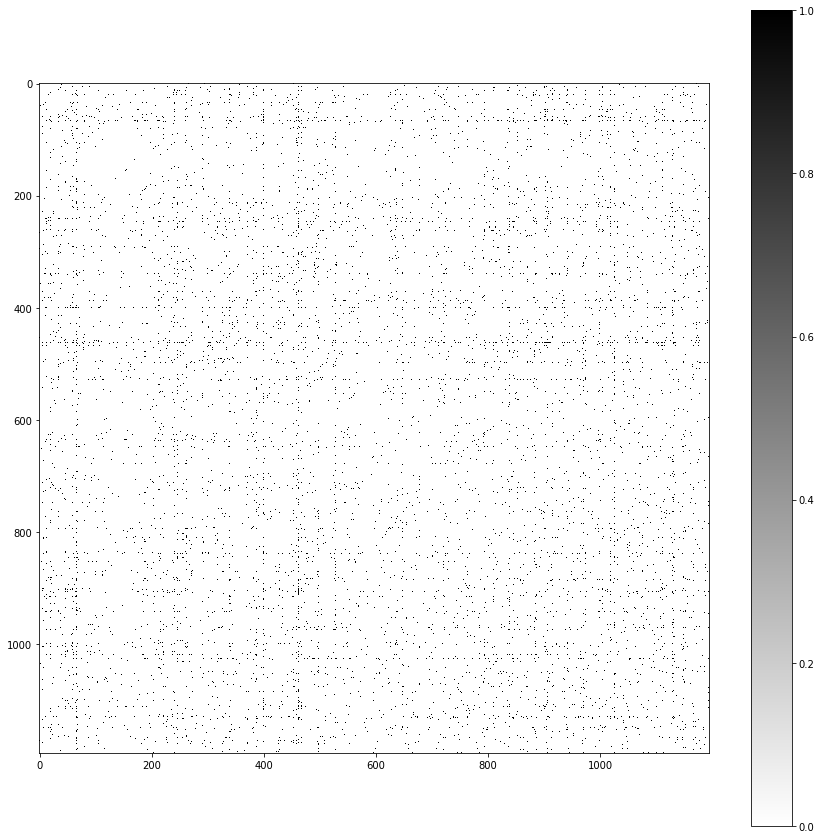

In [21]:
# Plot matrix heatmap
fig, ax = plt.subplots(figsize=(15, 15))
_ = plt.imshow(X, cmap ='binary')
_ = plt.colorbar()
_ = plt.show()

In [22]:
np.save('data/database/adj_mat',A)